# Titanic: Survival Prediction 

In [123]:
import pandas as pd
import numpy as np
import time as time
from IPython.display import display 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
% matplotlib inline 

from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import accuracy_score

#### Load in Data

In [124]:
try: #reading in data (training and testing)
    df_train_raw = pd.read_csv("./Data/train.csv",sep=",")
    df_test_raw = pd.read_csv("./Data/test.csv",sep=",")
    print("Data Successfuly Loaded")
    print("Total Observations: {}".format(df_train.shape[0]))
except Exception as e:
    print(str(e))

Data Successfuly Loaded
name 'df_train' is not defined


From the Titanic dataset, the features for each passenger on the ship are as follows:

- Survived: Outcome of survival (0 = No; 1 = Yes)
- Pclass: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- Name: Name of passenger
- Sex: Sex of the passenger
- Age: Age of the passenger (Some entries contain NaN)
- SibSp: Number of siblings and spouses of the passenger aboard
- Parch: Number of parents and children of the passenger aboard
- Ticket: Ticket number of the passenger
- Fare: Fare paid by the passenger
- Cabin Cabin number of the passenger (Some entries contain NaN)
- Embarked: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

### Training & Testing Set Preprocess

In [125]:
#Drop Columns not necessary for predictions:
def drop_columns(df,columns):
    '''Drop columns that are unimportant'''
    df = df.drop(columns,axis=1)
    return(df)

# Drop the observations that contain a NA in column
def drop_na(df):
    '''Drop observations with missing values'''
    df = df.dropna()
    print("Confirm rows with NA's are dropped:")
    print(df.isnull().sum())
    return(df)

In [128]:
### Training Set
columns_train = ['PassengerId','Name','Ticket','Cabin']
df_train  = drop_columns(df_train_raw,columns_train)
df_train_na = drop_na(df_train).reset_index()

Confirm rows with NA's are dropped:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [129]:
###Testing Set
#call the drop_na function and pass the reduced test set (i.e. with removed features)
columns_test = ['PassengerId']
df_test  = drop_columns(df_test_raw,columns_test)
df_test_na = drop_na(df_test).reset_index()

Confirm rows with NA's are dropped:
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [130]:
df_train.ix[:,1:].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,Southampton
1,1,female,38.0,1,0,71.2833,Cherbourg
2,3,female,26.0,0,0,7.9250,Southampton
3,1,female,35.0,1,0,53.1000,Southampton
4,3,male,35.0,0,0,8.0500,Southampton


In [131]:
#Assign Features and Labels
def get_features_label(df):
    X = df.ix[:,2:] #Features
    y = df.ix[:,1] # Labels
    return(X,y)

X1,y1 = get_features_label(df_train_na)
print("Total number of features: {}".format(X1.shape[1]))
print("Total number of observations: {}".format(X1.shape[0]))

Total number of features: 7
Total number of observations: 714


In [132]:
def get_dummy_vars(X):
    # Initialize new output DataFrame
    df_preprocess = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col_name, row in X.iteritems():
        
        print(col_name,row.dtype)
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if row.dtype == object:
            row = row.replace(['male', 'female'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if row.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            row = pd.get_dummies(row, prefix = col_name)

        # Collect the revised columns
        df_preprocess = df_preprocess.join(row)
    
    return df_preprocess

In [133]:
#check that the categorical variables are correctly modified
X_d = get_dummy_vars(X1)
display(X_d.head(2))

Pclass int64
Sex object
Age float64
SibSp int64
Parch int64
Fare float64
Embarked object


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0


## Build Predictive Model

- Base case: removing all of the missing values in each row per feature and splitting the "training" set into folds to perform cross-validation

In [134]:
def train_and_predict(clf,X_train,y_train,X_test,y_test):
    '''Build a Basic Model for Predictions'''
    '''No hyperparameters are tuned in this model'''
    
    #start time to run the model
    start = time.time()
   
    #fit classifier to the training set
    clf.fit(X_train,y_train)
    
    #predict using the Testing set held out from each fold
    y_pred = clf.predict(X_test)

    #Compute the accuracy for the actual label vs the predicted label
    acc = accuracy_score(y_test,y_pred)
    
    #stop timing run
    end  = time.time()
    
    #total run time
    total_time = end -start
    
    #modify format of time h:m:s
    m,s = divmod(total_time,60)
    h,m = divmod(m,60)
    time_format = "%d:%02d:%02d" % (h,m,s)
    return(acc,time_format)

In [135]:
def run_model(clf,X,y):
    print("Model:", clf.__class__.__name__)
    print("*******************************")

    #initialize empty dataframe to store iteration results
    df_summary = pd.DataFrame(columns=['Fold','Run Time','Accuracy'])

    #Perform Cross-Validation
    n_folds = 5 # number of fold; (i.e. 3, 5, or 10 are common; odd numbers perfered)
    kf = KFold(len(X),n_folds,shuffle=True,random_state=None)

    #iterate through the indicies identified from kf and assign training and test 
    # for x and y, respectively. Use '.loc' for slicing dataframe
    for index,(train_index,test_index) in list(enumerate(kf,start=1)):
        print("Fold: ",index)
        X_train = X.loc[train_index]; X_test = X.loc[test_index]
        y_train = y.loc[train_index]; y_test = y.loc[test_index]

        #Print out the dimensions of the training and testing sets
        #double check the dimensions are correct
        print("Train_Index:{}....".format(train_index[1:10]))
        print("Test_Index: {}....".format(test_index[1:10]))
        print("Train Size: ",X_train.shape[0])
        print("Test Size: ",X_test.shape[0])

        #Call the train_and_predict function and pass in training and testing sets
        acc, time_form = train_and_predict(clf,X_train,y_train,X_test,y_test)
        print("Run Time:", time_form)
        print("Accuracy: {0:.3f}%".format(acc*100))    

        #appending dataframe 
        df_summary = df_summary.append({'Fold': index,
                           'Run Time': time_form,
                           'Accuracy': acc},ignore_index=True)
        print("===================================================")

    print("\nSummary Statistics:")
    print(df_summary)

    print("\nAverage Accuracy: {0:.2f}%".format(df_summary['Accuracy'].mean()*100))

In [136]:
#considering the Naive Bayes Classification model for base case
clf = GaussianNB() 
run_model(clf,X_d,y1)

Model: GaussianNB
*******************************
Fold:  1
Train_Index:[ 1  4  5  6  7  8 10 11 13]....
Test_Index: [ 3  9 12 18 21 27 31 44 45]....
Train Size:  571
Test Size:  143
Run Time: 0:00:00
Accuracy: 74.126%
Fold:  2
Train_Index:[ 3  4  5  6  8  9 10 11 12]....
Test_Index: [ 1  7 13 22 24 32 37 38 48]....
Train Size:  571
Test Size:  143
Run Time: 0:00:00
Accuracy: 78.322%
Fold:  3
Train_Index:[ 1  2  3  4  5  6  7  9 10]....
Test_Index: [11 14 15 25 28 35 40 42 43]....
Train Size:  571
Test Size:  143
Run Time: 0:00:00
Accuracy: 79.720%
Fold:  4
Train_Index:[ 1  2  3  5  7  8  9 10 11]....
Test_Index: [ 6 17 19 23 26 33 34 36 39]....
Train Size:  571
Test Size:  143
Run Time: 0:00:00
Accuracy: 74.126%
Fold:  5
Train_Index:[ 1  2  3  4  6  7  8  9 11]....
Test_Index: [10 16 20 29 30 41 47 52 55]....
Train Size:  572
Test Size:  142
Run Time: 0:00:00
Accuracy: 74.648%

Summary Statistics:
   Fold Run Time  Accuracy
0   1.0  0:00:00  0.741259
1   2.0  0:00:00  0.783217
2   3.0 

## Sensitvity Analysis:

** Consider several data imputation methods. First, let's look at replacing the data with only the Median values for the respected feature columns (i.e. Age column)**

In [137]:
df_train  = drop_columns(df_train_raw,columns_train)
df_test  = drop_columns(df_test_raw,columns_test)

In [138]:
df_train['Age'].fillna(df_train[(df_train['Pclass'] == 1)]['Age'].median(),inplace=True)
df_train['Age'].fillna(df_train[(df_train['Pclass'] == 2)]['Age'].median(),inplace=True)
df_train['Age'].fillna(df_train[(df_train['Pclass'] == 3)]['Age'].median(),inplace=True)

In [139]:
#df_train.to_csv("./Data/medage.csv",header=True,sep=",")

In [140]:
#Assign Features and Labels
def get_features_label2(df):
    X = df.ix[:,1:] #Features
    y = df.ix[:,0] # Labels
    return(X,y)

X2,y2 = get_features_label2(df_train)
print("Total number of features: {}".format(X2.shape[1]))
print("Total number of observations: {}".format(X2.shape[0]))

Total number of features: 7
Total number of observations: 891


In [141]:
#check that the categorical variables are correctly modified
X_d2 = get_dummy_vars(X2)
display(X_d2.head(2))

Pclass int64
Sex object
Age float64
SibSp int64
Parch int64
Fare float64
Embarked object


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0


In [142]:
clf = GaussianNB() #Initialize classifier 
run_model(clf,X_d2,y2) #call run_model --> which calls train_and_predict

Model: GaussianNB
*******************************
Fold:  1
Train_Index:[1 2 3 4 5 6 7 8 9]....
Test_Index: [12 13 17 19 25 26 30 33 36]....
Train Size:  712
Test Size:  179
Run Time: 0:00:00
Accuracy: 77.095%
Fold:  2
Train_Index:[ 2  3  4  5  6  7  9 10 11]....
Test_Index: [ 8 20 21 22 23 32 34 39 44]....
Train Size:  713
Test Size:  178
Run Time: 0:00:00
Accuracy: 76.404%
Fold:  3
Train_Index:[ 1  2  3  4  5  6  8 10 11]....
Test_Index: [ 9 16 18 27 46 50 53 54 58]....
Train Size:  713
Test Size:  178
Run Time: 0:00:00
Accuracy: 80.337%
Fold:  4
Train_Index:[1 2 3 4 5 6 7 8 9]....
Test_Index: [29 31 37 38 60 74 76 78 79]....
Train Size:  713
Test Size:  178
Run Time: 0:00:00
Accuracy: 78.090%
Fold:  5
Train_Index:[ 7  8  9 10 12 13 16 17 18]....
Test_Index: [ 2  3  4  5  6 11 14 15 24]....
Train Size:  713
Test Size:  178
Run Time: 0:00:00
Accuracy: 79.775%

Summary Statistics:
   Fold Run Time  Accuracy
0   1.0  0:00:00  0.770950
1   2.0  0:00:00  0.764045
2   3.0  0:00:00  0.803371

## Exploratory Analysis

Survival Rate for Males: 18.891%
Survival Rate for Females: 74.204%


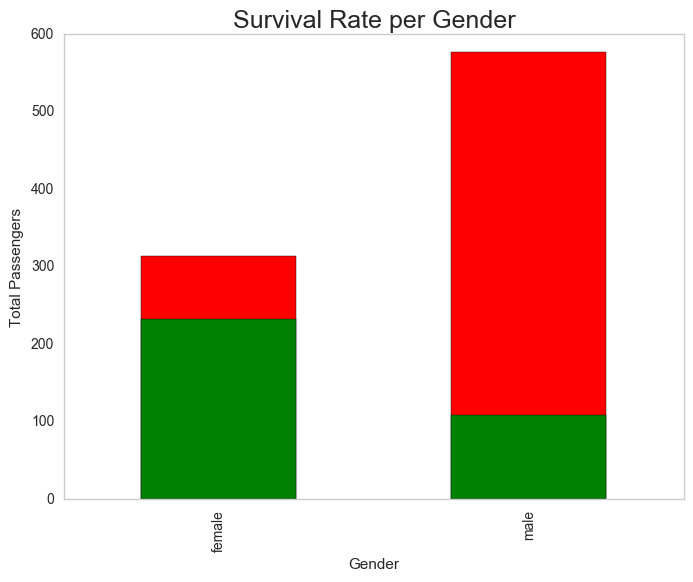

In [143]:
df = pd.DataFrame()
df['Total'] = df_train.groupby('Sex').size()
df['Survived'] = df_train.groupby('Sex').sum()['Survived']
df['Survival_Rate'] = (df['Survived']/ df['Total'])*100

print("Survival Rate for Males: {}%".format(np.round(df.ix[1,2],3)))
print("Survival Rate for Females: {}%".format(np.round(df.ix[0,2],3)))

plt.figure(figsize=(8,6))
df['Total'].plot(kind='bar',color='red')
df['Survived'].plot(kind='bar',color="green")
plt.xlabel("Gender")
plt.ylabel("Total Passengers")
plt.title("Survival Rate per Gender",fontsize=18)

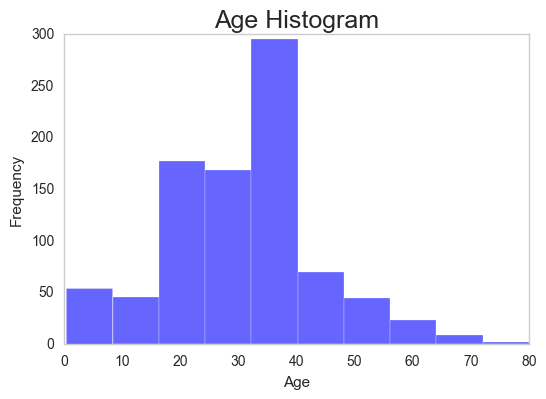

In [144]:
df_train['Age'].plot(kind='hist',color="blue",edgecolor="w",alpha=0.60)
plt.title("Age Histogram",fontsize=18)
plt.xlabel("Age")

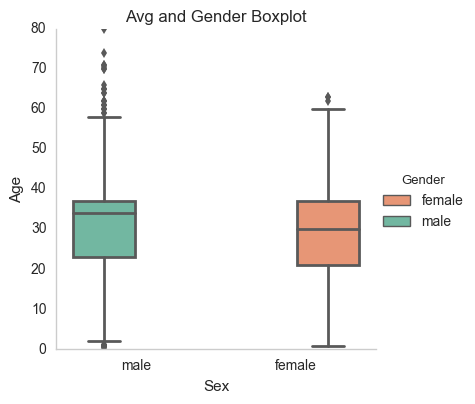

In [145]:
plt.figure(figsize=(6,6))
g = sns.factorplot("Sex", hue="Sex", y="Age", data=df_train, kind="box",
                   linewidth=2.0,palette="Set2")
g.add_legend(title="Gender")
plt.title("Avg and Gender Boxplot")
plt.show()

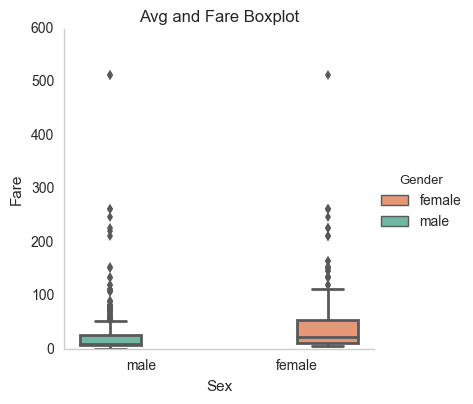

In [146]:
plt.figure(figsize=(6,6))
g = sns.factorplot("Sex", hue="Sex", y="Fare", data=df_train, kind="box",
                   linewidth=2.0,palette="Set2")
g.add_legend(title="Gender")
plt.title("Avg and Fare Boxplot")
plt.show()